# Daymet V4 - Deriving 30-yr Normals and Anomalies

*Author:  ORNL DAAC*
<br>
*Date: August 31, 2021*
<br>
*Contact for [ORNL DAAC](https://daac.ornl.gov/):  uso@daac.ornl.gov*

##### Keywords:  ORNL DAAC, Daymet, THREDDS, OPeNDAP, Earthdata, Python, xarray

## Overview
## Source Data
* [Daymet V4 Annual Climatologies](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1852)
* [Daymet V4 Monthly Climatologies](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1855)
* [Daymet V4 Daily files - Lower Latency](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1904)

### Requirements
* Python 3.7 or higher
* geopandas and dependencies
* pydap
* xarray
* rasterio
* shapely

***
***

## Tutorial

In this tutorial, we'll demonatrate how to programmatically search for and subset Daymet V4 Annual Climatologies and Monthly Climatologies.  We'll also access the Daymet V4 Daily Lower Latency files.    

We'll use Python's **`Xarray`** Package to examine the data and develop other climatological products. 

Steps
1. Establish search parameters based on a polygon boundary file and other criteria for subsetting Daymet Data
1. Using Search Parameters, programatically search NASA's Earthdata Holdings, subset, and download files of interest
1. 
1. 


## Step 1.  Polygon Boundary Area Parameters for Subsetting

We'll start by establishing search and subsetting parameters based on a vector file.

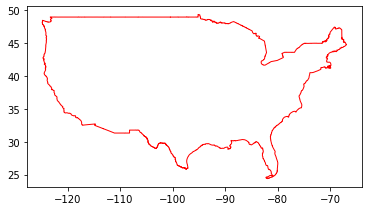

In [1]:
import geopandas as gpd
conus_poly = gpd.read_file('bnds/conus_singlepart.shp')
ax = conus_poly.plot(color = 'none', edgecolor = 'red')

In [2]:
conus_poly.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin Island

In [3]:
xy = conus_poly.crs.area_of_use.bounds # bound of polygon in lat, lon
print("area_of_use:", xy)
print(' ')
conus_poly_4326 = conus_poly.to_crs(epsg=4326)
xy_4326 = conus_poly_4326.bounds # bound of the conus polygon in lat, lon
print(xy_4326)
print(' ')
xy_list = xy_4326.values.tolist()[0]
print(xy_list)

area_of_use: (167.65, 14.92, -47.74, 86.46)
 
         minx       miny       maxx       maxy
0 -124.848974  24.396308 -66.885075  49.384358
 
[-124.84897400000001, 24.39630800000002, -66.88507499999997, 49.38435799999999]


In [4]:
xy_list = conus_poly_4326.bounds.values.tolist()[0] # create a python list to pass later as a search parameter
print(xy_list)

[-124.84897400000001, 24.39630800000002, -66.88507499999997, 49.38435799999999]


In [5]:
# Do I need this block ??  This seems another way to get the correct bounding box
conus_poly_bounds = conus_poly.bounds # bounding box of the CONUS polygon file 
print('Bbounding box of the CONUS polygon file')
conus_poly_bounds

Bbounding box of the CONUS polygon file


,minx,miny,maxx,maxy
0,-124.848974,24.396308,-66.885075,49.384358


In [6]:
daymet_proj = "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"
conus_poly_lcc = conus_poly.to_crs(daymet_proj) # to_crs re-projects from UTM 17N to LCC
conus_poly_lcc.crs

<Projected CRS: +proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.31424 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
# We'll use the boounding box of the polygon file in Lambert Conformal Conic projection to subset the actual data 
# using OPeNDAP protocols.  
lccbounds = conus_poly_lcc.bounds # Bounds in LCC projection
print('Projected bounding box of the CONUS polygon file in LCC projection')
lccbounds

Projected bounding box of the CONUS polygon file in LCC projection


,minx,miny,maxx,maxy
0,-1.956186e+06,-1.785922e+06,2.433990e+06,946300.543092


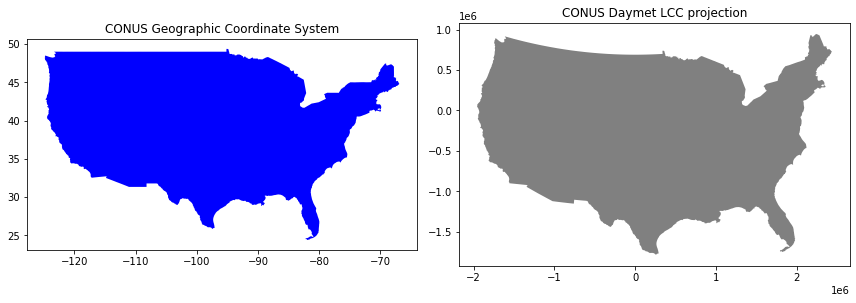

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
conus_poly.plot(ax=ax1, facecolor='blue');
ax1.set_title("CONUS Geographic Coordinate System");
conus_poly_lcc.plot(ax=ax2, facecolor='grey');
ax2.set_title("CONUS Daymet LCC projection");
plt.tight_layout()

## Step 2.  Setting Up Search Parameters - Annual Climatology

We'll use the Dataset DOI of the **`Daymet V4 Annual Climatologies`** in this exercise.  These prederived climatologies are available as a unique dataset. 

[Daymet V4 Annual Climatologies](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1852) 

<div class="alert alert-block alert-info">
Daymet V4 Annual Climatologies DOI: https://doi.org/10.3334/ORNLDAAC/1852  
</div>


In [9]:
import requests
daymet_doi = '10.3334/ORNLDAAC/1852' # ANNUAL CLIMATES define the DOI as the variable `daymet_doi`
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
doisearch = cmrurl + 'collections.json?doi=' + daymet_doi # 
print('Earthdata Metadata for DaymetV4 Annual Climatologies --> ' , doisearch)

Earthdata Metadata for DaymetV4 Annual Climatologies -->  https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.3334/ORNLDAAC/1852


In [10]:
response = requests.get(doisearch)
collection = response.json()['feed']['entry'][0]
#print(collection)
concept_id = collection['id']
print('NASA Earthdata Cloud-based Concept_ID --> ' , concept_id)

NASA Earthdata Cloud-based Concept_ID -->  C2024906228-ORNL_CLOUD


#### We'll set the time period of interest from which to subset data.

For this exercise, we'll search for and access 30 years of data, from 1991 to 2020.

In [11]:
import datetime as dt 
# We'll download 30 years of data starting in 1991 and ending in 2020.
start_date = dt.datetime(1991, 1, 1) # specify your own start date
end_date = dt.datetime(2020, 12, 31)  # specify your end start date

print(start_date,end_date,sep='\n')

dt_format = '%Y-%m-%dT%H:%M:%SZ' # format requirement for datetime search
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)
print(temporal_str)


1991-01-01 00:00:00
2020-12-31 00:00:00
1991-01-01T00:00:00Z,2020-12-31T00:00:00Z


#### Let's examine all of the search parameters we've established.

In [12]:
var = 'tmax' # select your own variable

print('Variables we have defined to pass to the CMR API')
print('-----------------------------------------------')
print('time range      :', temporal_str)
print('Daymet variable :', var)
print('bounding box    :')
print(xy_list)
print('concept ID      :', concept_id)
print('cmr url         :', cmrurl)

Variables we have defined to pass to the CMR API
-----------------------------------------------
time range      : 1991-01-01T00:00:00Z,2020-12-31T00:00:00Z
Daymet variable : tmax
bounding box    :
[-124.84897400000001, 24.39630800000002, -66.88507499999997, 49.38435799999999]
concept ID      : C2024906228-ORNL_CLOUD
cmr url         : https://cmr.earthdata.nasa.gov/search/


### Step 2.1 Search for granules within parameters

Now that we've established the search parameters, lets search for files within the dataset that are within our search parameters.

In [13]:
granulesearch = cmrurl + 'granules.json?collection_concept_id=' + concept_id + \
                '&page_size=1000' + '&temporal=' + temporal_str + \
                '&bounding_box[]=' + ','.join(map(str, xy_list))
print(granulesearch) 

https://cmr.earthdata.nasa.gov/search/granules.json?collection_concept_id=C2024906228-ORNL_CLOUD&page_size=1000&temporal=1991-01-01T00:00:00Z,2020-12-31T00:00:00Z&bounding_box[]=-124.84897400000001,24.39630800000002,-66.88507499999997,49.38435799999999


By clicking on the CMR URL above, you will see NASA's common metadata repository (CMR) for the Daymet V4 Annual Climatologies.  We can search within this to find the individual files (or granules) that we are interested in based on the search parameters we defined in **`granulesearch`**. 

In [14]:
response = requests.get(granulesearch)
granules = response.json()['feed']['entry']  
granule_names = []  # A Python list of granule_names found in the CMR URL based on our search criteria

for g in granules:
    granule_name = g['title']
    if var in granule_name:
        granule_names.append(granule_name)
        print(granule_name)

Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1991.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1991.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1992.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1992.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1993.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1993.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1994.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1994.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1995.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1995.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1996.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1996.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1997.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1997.nc
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1998.tif
Daymet_V4_Annual_Climatology.daymet_v4_tmax_annavg_na_1998.nc


**We see that we have the years of interest (1991 - 2020) and the variable of interest (tmax), but we'll further reduce this to only the netCDF files (available thru OPeNDAP) below.**  

**Just the North American (na) files are listed because they are within the spatial domain of CONUS, which we established in our search.**

### Step 2.2 Programmatically access, subset, and download: Daymet V4 Annual Climate files

We'll use Pythons **`pydap`** library and the bounding box of the polygon file.

* **`pydap`** can be used to inspect data from any scientific dataset available on the internet from OPeNDAP servers. This allows inspection and manipulation of scientific data as if it were stored locally.  Data can be downloaded on-the-fly as needed.

Pydap Xarray open_dataset *Parameters*
* **[xarray.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)** 

In [ ]:
###### DO NOT RUN IN WEBINAR #####
# Programmatically select for netCDF files
from pydap.client import open_url
from pydap.cas.urs import setup_session # setup_session 
import xarray as xr
import time

before = time.time()
cnt = 0
for g_name in granule_names: 
    if '.nc' in g_name:
        print(' ***GRANULE_NAME*** ---->', g_name)
        thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1852/'
        granule_dap = thredds_url + g_name.replace('Daymet_V4_Annual_Climatology.','')
        #print(granule_dap)
        
        thredds_ds = open_url(granule_dap) #, session=session)  
        #print('thredds_ds ----->', thredds_ds)
        ds = xr.open_dataset(xr.backends.PydapDataStore(thredds_ds), decode_coords="all")
    
        #print(ds)
        
        temp=ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]))
    
        if cnt==0:
            tmax = temp
        else:
            tmax = xr.concat([tmax, temp], dim="time")
    
        cnt += 1
    

# save concatenated file (eg. 30 time steps; 1991- 2020) to netcdf
#tmax.to_netcdf(var + '_concatAnnAvg_conussubset.nc') # this file is opened below
tmax.to_netcdf(var + '_concatAnnAvg_conussubset_demo.nc') # this file is a "demo" for the webinar
print("Processing Time: ", time.time() - before, 'seconds')
#Processing Time:  338.2726831436157 seconds (about 5 1/2 min.)

The step above takes me about 5 minues to run.  That's accessing the data, subsetting to a region of interest and our times of interest, and concatending 30 years of data into one file.  That's pretty good compared to downloading each file separately and doing the subsetting in a separate system.

**View the netCDF file just created:  `tmax_concatAnnAvg_conussubset.nc`**

## Step 3. 30-years (1991 - 2020) of Annual Average Maximum Temperture 


### Xarray
We'll use the Python Package **`Xarray`** to explore and analyze the 30yr Annual Mean Maximum Temperature dataset we've downloaded.

[**`Xarray`**](http://xarray.pydata.org/en/stable/) is "an open source project and Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun!"

[Xarray](http://xarray.pydata.org/en/stable/) introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience. The package includes a large and growing library of domain-agnostic functions for advanced analytics and visualization with these data structures.

Xarray is particularly tailored to working with netCDF files, which were the source of xarray’s data model.  Xarray allows label-based indexing from the array of data.  And so, for example, select timeseries data by date/time instead of index position.

More on Xarray https://www.youtube.com/watch?v=a339Q5F48UQ
 


### Step 3.1 Explore the 30-years Maximum Temperature File in Xarray

#### Use Xarray's **`open_dataset`**  to open the file we subset and downloaded above.

In [15]:
import xarray as xr
ds_tmax_concatAnnAvg = xr.open_dataset('derived_nc_files/tmax_concatAnnAvg_conussubset.nc') 

#netCDF file representation
ds_tmax_concatAnnAvg.info()

xarray.Dataset {
dimensions:
	time = 30 ;
	x = 4390 ;
	y = 2732 ;

variables:
	float32 x(x) ;
		x:units = m ;
		x:long_name = x coordinate of projection ;
		x:standard_name = projection_x_coordinate ;
		x:_ChunkSizes = 7814 ;
	float32 lat(y, x) ;
		lat:units = degrees_north ;
		lat:long_name = latitude coordinate ;
		lat:standard_name = latitude ;
		lat:_ChunkSizes = [1010  977] ;
	float32 lon(y, x) ;
		lon:units = degrees_east ;
		lon:long_name = longitude coordinate ;
		lon:standard_name = longitude ;
		lon:_ChunkSizes = [1010  977] ;
	float32 y(y) ;
		y:units = m ;
		y:long_name = y coordinate of projection ;
		y:standard_name = projection_y_coordinate ;
		y:_ChunkSizes = 8075 ;
	float32 tmax(time, y, x) ;
		tmax:units = degrees C ;
		tmax:cell_methods = area: mean time: maximum within days time: mean over days ;
		tmax:long_name = annual average of daily maximum temperature ;
		tmax:_ChunkSizes = [   1 1000 1000] ;
		tmax:grid_mapping = lambert_conformal_conic ;
	datetime64[ns] tim

In [16]:
# Xarray's (html) representation
ds_tmax_concatAnnAvg

<xarray.Dataset>
Dimensions:                  (time: 30, x: 4390, y: 2732)
Coordinates:
  * x                        (x) float32 -1.955e+06 -1.954e+06 ... 2.434e+06
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * y                        (y) float32 9.46e+05 9.45e+05 ... -1.785e+06
  * time                     (time) datetime64[ns] 1991-07-02T12:00:00 ... 20...
Data variables:
    tmax                     (time, y, x) float32 ...
    lambert_conformal_conic  int16 ...

In [17]:
ds_tmax_concatAnnAvg.data_vars

Data variables:
    tmax                     (time, y, x) float32 ...
    lambert_conformal_conic  int16 -32767

#### Now lets look at the **`Data Array`** of maximum temperature

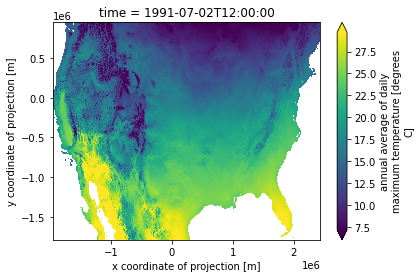

In [18]:
ds_tmax_concatAnnAvg.tmax[0].plot(robust=True) # Plot the first year (1991) of the 30-year concatenated fil

In [19]:
# Looking at the numpy array of Annual Average Maximum Temperature data - for one year
ds_tmax_concatAnnAvg.tmax[0].data

#can also look at the values of the coordinates
#ds_tmax_30yr.tmax.x
#ds_tmax_30yr.tmax.y

array([[      nan,       nan,       nan, ..., 10.916137, 10.836356,
        10.892082],
       [      nan,       nan,       nan, ..., 10.83189 , 10.813479,
        10.875671],
       [      nan,       nan,       nan, ..., 10.784274, 10.840438,
        10.822877],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)

In [20]:
ds_tmax_concatAnnAvg.tmax.dims
# Here we can see the arrangment of the dimensions.  Time is the first dimension.

('time', 'y', 'x')

In [21]:
ds_tmax_concatAnnAvg.tmax[0]

<xarray.DataArray 'tmax' (y: 2732, x: 4390)>
[11993480 values with dtype=float32]
Coordinates:
  * x        (x) float32 -1.955e+06 -1.954e+06 ... 2.433e+06 2.434e+06
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
  * y        (y) float32 9.46e+05 9.45e+05 9.44e+05 ... -1.784e+06 -1.785e+06
    time     datetime64[ns] 1991-07-02T12:00:00
Attributes:
    units:         degrees C
    cell_methods:  area: mean time: maximum within days time: mean over days
    long_name:     annual average of daily maximum temperature
    _ChunkSizes:   [   1 1000 1000]
    grid_mapping:  lambert_conformal_conic

In [22]:
da_tmax_concatAnnAvg = ds_tmax_concatAnnAvg["tmax"]
da_tmax_concatAnnAvg

<xarray.DataArray 'tmax' (time: 30, y: 2732, x: 4390)>
[359804400 values with dtype=float32]
Coordinates:
  * x        (x) float32 -1.955e+06 -1.954e+06 ... 2.433e+06 2.434e+06
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
  * y        (y) float32 9.46e+05 9.45e+05 9.44e+05 ... -1.784e+06 -1.785e+06
  * time     (time) datetime64[ns] 1991-07-02T12:00:00 ... 2020-07-01T12:00:00
Attributes:
    units:         degrees C
    cell_methods:  area: mean time: maximum within days time: mean over days
    long_name:     annual average of daily maximum temperature
    _ChunkSizes:   [   1 1000 1000]
    grid_mapping:  lambert_conformal_conic

#### Positional Indexing
* **`isel`** is *positional* Indexing using dimension names

In [23]:
da_tmax_concatAnnAvg.isel(y=1500, x=1500)#.plot()   #isel - the position index along the array

<xarray.DataArray 'tmax' (time: 30)>
array([12.344137, 12.065014, 12.376328, 13.541863, 13.363562, 13.897261,
       12.812246, 13.482438, 13.968849, 14.673343, 14.564301, 14.666849,
       14.851891, 13.60326 , 14.139589, 14.210465, 14.139288, 13.511206,
       13.918877, 14.249644, 14.245973, 15.524986, 13.378959, 14.017096,
       14.205288, 14.548356, 14.769013, 15.041945, 13.637424, 15.416986],
      dtype=float32)
Coordinates:
    x        float32 -4.552e+05
    lat      float32 ...
    lon      float32 ...
    y        float32 -5.54e+05
  * time     (time) datetime64[ns] 1991-07-02T12:00:00 ... 2020-07-01T12:00:00
Attributes:
    units:         degrees C
    cell_methods:  area: mean time: maximum within days time: mean over days
    long_name:     annual average of daily maximum temperature
    _ChunkSizes:   [   1 1000 1000]
    grid_mapping:  lambert_conformal_conic

In [24]:
da_tmax_concatAnnAvg.sel(y=-554000.0, x=-455250.0)#.plot()

<xarray.DataArray 'tmax' (time: 30)>
array([12.344137, 12.065014, 12.376328, 13.541863, 13.363562, 13.897261,
       12.812246, 13.482438, 13.968849, 14.673343, 14.564301, 14.666849,
       14.851891, 13.60326 , 14.139589, 14.210465, 14.139288, 13.511206,
       13.918877, 14.249644, 14.245973, 15.524986, 13.378959, 14.017096,
       14.205288, 14.548356, 14.769013, 15.041945, 13.637424, 15.416986],
      dtype=float32)
Coordinates:
    x        float32 -4.552e+05
    lat      float32 ...
    lon      float32 ...
    y        float32 -5.54e+05
  * time     (time) datetime64[ns] 1991-07-02T12:00:00 ... 2020-07-01T12:00:00
Attributes:
    units:         degrees C
    cell_methods:  area: mean time: maximum within days time: mean over days
    long_name:     annual average of daily maximum temperature
    _ChunkSizes:   [   1 1000 1000]
    grid_mapping:  lambert_conformal_conic

#### Portland, Oregon - Geographic Location:  45.52, -122.681944
* Determine the Daymet LCC x,y location for Portland, OR

In [25]:
from shapely.geometry import Point
import pyproj
# daymet_proj = "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"

portland_lat = [45.52]
portland_lon = [-122.681944]
crs = {'init': 'epsg:4326'}

#geometry = [Point(xy) for xy in zip(portland_lon,portland_lat)]
df = [Point(xy) for xy in zip(portland_lon,portland_lat)]
df
geo_portland = gpd.GeoDataFrame(df, crs = crs, geometry=df)
geo_portland
lcc_portland = geo_portland.to_crs(daymet_proj)
lcc_portland.bounds

C:\Users\myt\Anaconda3\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,minx,miny,maxx,maxy
0,-1.670075e+06,548466.995525,-1.670075e+06,548466.995525


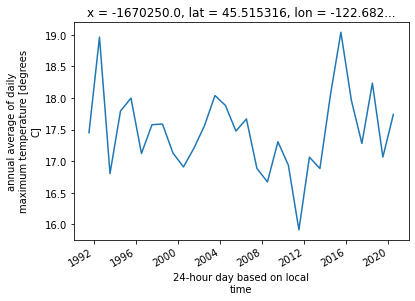

In [26]:
da_tmax_concatAnnAvg.sel(y=548466.996, x=-1670074.829, method="nearest").plot()  #(minx -1670074.829, miny 548466.996)

### 3.2 Maximum Temperature : 30-year Climate Normal 

The [National Centers for Environmental Information (NCEI)](https://www.ncei.noaa.gov/products/land-based-station/us-climate-normals) defines a **`Climate Normal`** as:

A "normal" is the 30-year average of a particular variable’s measurements, calculated for a uniform time period. Climate normals are derived from weather and climate observations captured by weather stations. The NCEI has produced the 1991–2020 U.S. Climate Normals as the latest in a series of decadal normals first produced in the 1950s.

Xarray allows a simple **`data reduction`** (reducing the data array along some dimension), resulting in a 30-year average Maximum Temperature Normal.

In [27]:
tmax_30yrNormal_1991_2020 = ds_tmax_concatAnnAvg.mean('time')
tmax_30yrNormal_1991_2020

<xarray.Dataset>
Dimensions:                  (x: 4390, y: 2732)
Coordinates:
  * x                        (x) float32 -1.955e+06 -1.954e+06 ... 2.434e+06
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * y                        (y) float32 9.46e+05 9.45e+05 ... -1.785e+06
Data variables:
    tmax                     (y, x) float32 nan nan nan nan ... nan nan nan nan
    lambert_conformal_conic  float64 -3.277e+04

Text(0.5, 0.98, '30-yr Normal Maximum Temperature: Annual')

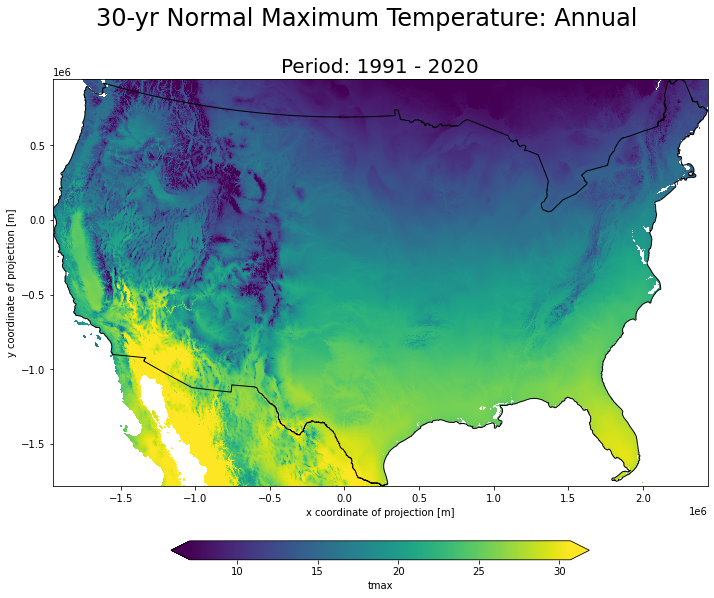

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,10))
tmax_30yrNormal_1991_2020.tmax.plot(ax=ax, robust=True, cbar_kwargs={"orientation": "horizontal","shrink": 0.5, "pad": 0.1})
conus_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'black')
ax.set_title('Period: 1991 - 2020', fontsize=20)
fig.suptitle("30-yr Normal Maximum Temperature: Annual", fontsize=24)

In [ ]:
#save using to_netcdf method

---
---

## Step 4.  Monthly (June) Normal and Anomaly from Daymet V4 Monthly Climatologies

In this next step, we'll create a Normal, but instead of an Annual Normal, we'll create a Monthly Normal.  Then we'll calculate the anomaly for this past June.  

We'll use the Dataset DOI of the **`Daymet V4 Monthly Climatologies`** in this exercise.  These prederived climatologies are available as a unique dataset. 

[Daymet V4 Monthly Climatologies](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1855) 

<div class="alert alert-block alert-info">
Daymet V4 Monthly Climatologies DOI: https://doi.org/10.3334/ORNLDAAC/1855  
</div>


### Step 4.1.  Monthly Climatologies - Setting Up Search Parameters

In [29]:
import requests
m_daymet_doi = '10.3334/ORNLDAAC/1855' # Monthly CLIMATES DOI
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
m_doisearch = cmrurl + 'collections.json?doi=' + m_daymet_doi # 
print('Earthdata Metadata for DaymetV4 Monthly Climatologies --> ' , m_doisearch)

m_response = requests.get(m_doisearch)
m_collection = m_response.json()['feed']['entry'][0]
#print(collection)
m_concept_id = m_collection['id']
print('NASA Earthdata Cloud-based Concept_ID Monthly Climates --> ' , m_concept_id)

import datetime as dt 
# We'll set up the same 30year Normal starting in 1991.
start_date = dt.datetime(1991, 1, 1) # specify your own start date
end_date = dt.datetime(2020, 12, 31)  # specify your end start date

dt_format = '%Y-%m-%dT%H:%M:%SZ' # format requirement for datetime search
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

print(' ')
var = 'tmax' # select your own variable

print('Variables we have defined to pass to the CMR API')
print('-----------------------------------------------')
print('time range      :', temporal_str)
print('Daymet variable :', var)
print('bounding box    :')
print(xy_list)
print('concept ID      :', m_concept_id)
print('cmr url         :', cmrurl)

Earthdata Metadata for DaymetV4 Monthly Climatologies -->  https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.3334/ORNLDAAC/1855
NASA Earthdata Cloud-based Concept_ID Monthly Climates -->  C2024906320-ORNL_CLOUD
 
Variables we have defined to pass to the CMR API
-----------------------------------------------
time range      : 1991-01-01T00:00:00Z,2020-12-31T00:00:00Z
Daymet variable : tmax
bounding box    :
[-124.84897400000001, 24.39630800000002, -66.88507499999997, 49.38435799999999]
concept ID      : C2024906320-ORNL_CLOUD
cmr url         : https://cmr.earthdata.nasa.gov/search/


### **Step 4.2. Monthly Climates - Setting up CMR URL with Search Parameters and Making File List**

In [30]:
m_granulesearch = cmrurl + 'granules.json?collection_concept_id=' + m_concept_id + \
                '&page_size=1000' + '&temporal=' + temporal_str + \
                '&bounding_box[]=' + ','.join(map(str, xy_list))
print(m_granulesearch)

response = requests.get(m_granulesearch)
m_granules = response.json()['feed']['entry']  
m_granule_names = []

for g in m_granules:
    m_granule_name = g['title']
    if var in m_granule_name:
        m_granule_names.append(m_granule_name)
        print(m_granule_name)

https://cmr.earthdata.nasa.gov/search/granules.json?collection_concept_id=C2024906320-ORNL_CLOUD&page_size=1000&temporal=1991-01-01T00:00:00Z,2020-12-31T00:00:00Z&bounding_box[]=-124.84897400000001,24.39630800000002,-66.88507499999997,49.38435799999999
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1991.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1991.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1992.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1992.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1993.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1993.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1994.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1994.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1995.nc
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1995.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_monavg_na_1996.tif
Daymet_V4_Monthly_Climatology.daymet_v4_tmax_mon

### Step 4.2.a. Examine one Monthly File to See Internal Structure

In [31]:
# Let's use Pydap and Xarray to look into *ONE* of the monthly netCDF files to examine the structure of the netCDF file
from pydap.client import open_url
from pydap.cas.urs import setup_session # setup_session 
import xarray as xr

m1_granule_dap = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1855/daymet_v4_tmax_monavg_na_1991.nc'

m1_thredds_ds = open_url(m1_granule_dap)
ds_tmax_monavg_na_1991 = xr.open_dataset(xr.backends.PydapDataStore(m1_thredds_ds), decode_coords="all")

#ds_tmax_monavg_na_1991.info()  #netCDF file representation 

ds_tmax_monavg_na_1991  ## Xarray's html representation


<xarray.Dataset>
Dimensions:                  (nv: 2, time: 12, x: 7814, y: 8075)
Coordinates:
    time_bnds                (time, nv) datetime64[ns] ...
    lambert_conformal_conic  int16 ...
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 1991-01-16T12:00:00 ... 19...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
Dimensions without coordinates: nv
Data variables:
    tmax                     (time, y, x) float32 ...
Attributes:
    start_year:                      1991
    source:                          Daymet Software Version 4.0
    Version_software:                Daymet Software Version 4.0
    Version_data:                    Daymet Data Version 4.0
    Conventions:                     CF-1.6
    citation:                        Please see http://daymet.ornl.gov/ for c...
    references:                      Please see http://daymet.ornl.gov/ for c...
    NCO:                             netCDF Operators version 4.9.3 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

### Step 4.3. Subset Monthly Maximum Temperature Climatologies to CONUS and June
**We'll narrow the granules to netCDF files and add a *`TIME SLICE`* to extract only the June Files**

Xarray allows us to use real time representation, instead of indexing, to slice.

In [ ]:
##### DO NOT RUN DURING WEBINAR #####
# Programmatically select for netCDF files
# Subset and concatenate June files into one netCDF file
# Save file as tmax_concatJuneMonAvg_conussubset.nc - 30 years of June - 1991-2020
from pydap.client import open_url
from pydap.cas.urs import setup_session # setup_session 
import xarray as xr
import time

#m_granule_name = 'daymet_v4_tmax_monavg_na_1991.nc'
#m_thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1855/'
#m_granule_dap = thredds_url + m_granule_name
#print(m_granule_dap)

#m_thredds_ds = open_url(m_granule_dap)
#ds_tmax_monavg_na_1991 = xr.open_dataset(xr.backends.PydapDataStore(m_thredds_ds), decode_coords="all")
before = time.time()
cnt = 0
for m_g_name in sorted(m_granule_names): 

    if '.nc' in m_g_name:
        print(' ***GRANULE_NAME*** ---->', m_g_name)
        m_thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1855/'
        m_granule_dap = m_thredds_url + m_g_name.replace('Daymet_V4_Monthly_Climatology.','')
        #print(m_granule_dap)
        
        m_thredds_ds = open_url(m_granule_dap) #, session=session)  
        m_ds = xr.open_dataset(xr.backends.PydapDataStore(m_thredds_ds), decode_coords="all")
        #print(m_ds)
        
        yr = m_ds.start_year # start_year is read from the global attributes of the file granule
        m_temp=m_ds['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]),
                                time=slice(dt.datetime((yr), 6, 16), (dt.datetime((yr), 7, 16))))
        if cnt==0:
            m_tmax = m_temp
        else:
            m_tmax = xr.concat([m_tmax, m_temp], dim="time")
    
        cnt += 1
    

# save concatenated file (eg. 30 June time steps; 1991- 2020) to netcdf
# m_tmax.to_netcdf(var + '_concatJuneMonAvg_conussubset.nc') # this file is opened below
m_tmax.to_netcdf(var + '_concatJuneMonAvg_conussubset_demo.nc') # this file is a "demo" for the webinar
print("Processing Time: ", time.time() - before, 'seconds')
# Processing Time:  355.2422912120819 seconds (about 6 min.)

In [32]:
ds_tmax_concatJuneMonAvg = xr.open_dataset('derived_nc_files/tmax_concatJuneMonAvg_conussubset.nc') 

#netCDF file representation
#ds_tmax_concatJuneMonAvg.info()

In [33]:
# Let's look at the time coordinate for the concatenated file
ds_tmax_concatJuneMonAvg.tmax.time

<xarray.DataArray 'time' (time: 30)>
array(['1991-06-16T00:00:00.000000000', '1992-06-16T00:00:00.000000000',
       '1993-06-16T00:00:00.000000000', '1994-06-16T00:00:00.000000000',
       '1995-06-16T00:00:00.000000000', '1996-06-16T00:00:00.000000000',
       '1997-06-16T00:00:00.000000000', '1998-06-16T00:00:00.000000000',
       '1999-06-16T00:00:00.000000000', '2000-06-16T00:00:00.000000000',
       '2001-06-16T00:00:00.000000000', '2002-06-16T00:00:00.000000000',
       '2003-06-16T00:00:00.000000000', '2004-06-16T00:00:00.000000000',
       '2005-06-16T00:00:00.000000000', '2006-06-16T00:00:00.000000000',
       '2007-06-16T00:00:00.000000000', '2008-06-16T00:00:00.000000000',
       '2009-06-16T00:00:00.000000000', '2010-06-16T00:00:00.000000000',
       '2011-06-16T00:00:00.000000000', '2012-06-16T00:00:00.000000000',
       '2013-06-16T00:00:00.000000000', '2014-06-16T00:00:00.000000000',
       '2015-06-16T00:00:00.000000000', '2016-06-16T00:00:00.000000000',
       '2017-06-16T00:00:00.000000000', '2018-06-16T00:00:00.000000000',
       '2019-06-16T00:00:00.000000000', '2020-06-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1991-06-16 1992-06-16 ... 2020-06-16
Attributes:
    standard_name:  time
    long_name:      24-hour day based on local time
    _ChunkSizes:    1

### Step 4.4. Derive 30-yr June Normal (1991 - 2021)

In [34]:
# Here, we are deriving and plotting the 30yr Normal for the month of June
tmax_30yrJuneNormal_1991_2020 = ds_tmax_concatJuneMonAvg.mean('time')

Text(0.5, 0.98, '30-yr Normal Maximum Temperature: June')

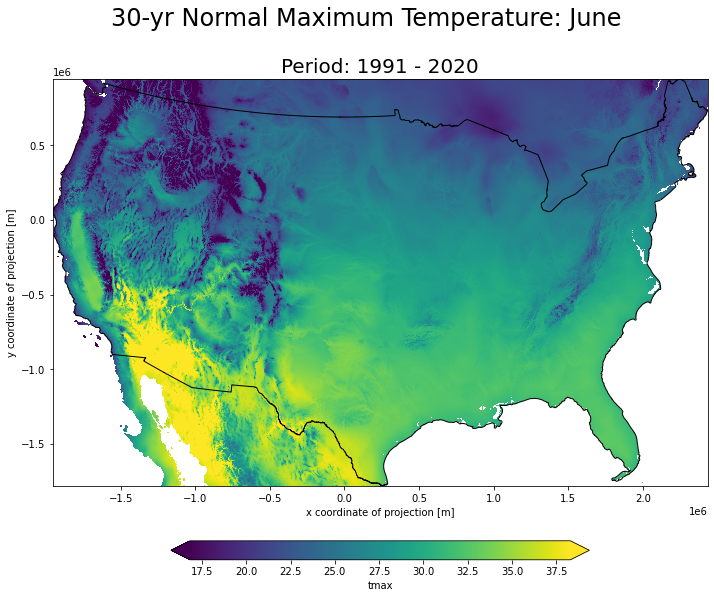

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,10))
tmax_30yrJuneNormal_1991_2020.tmax.plot(ax=ax, robust=True, cbar_kwargs={"orientation": "horizontal","shrink": 0.5, "pad": 0.1})
conus_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'black')
ax.set_title('Period: 1991 - 2020', fontsize=20)
fig.suptitle("30-yr Normal Maximum Temperature: June", fontsize=24)

In [36]:
tmax_30yrJuneNormal_1991_2020.to_netcdf(var + '_30yrJuneNormal_conus.nc')

### Step 4.5. Access June 2021 Daily Lower Latency Files

For 2021, Daymet V4 Daily data are now being produced on a monthly update cycle.

Those [data](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1904/catalog.html) are, at the time of this webinar, are hosted on the ORNL DAAC THREDDS Data Server and [OPeNDAP](https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1904/daymet_v4ll_daily_na_tmax_202106.nc) 

A sample file name is:  **daymet_v4ll_daily_na_tmax_202106.nc**

In [37]:
# OPeNDAP URL : https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1904/daymet_v4ll_daily_na_tmax_202106.nc
ll_granule_name = 'daymet_v4ll_daily_na_tmax_202106.nc'
ll_thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1904/'
ll_granule_dap = ll_thredds_url + ll_granule_name
print(ll_granule_dap)

ll_thredds_ds = open_url(ll_granule_dap)
ds_tmax_202106 = xr.open_dataset(xr.backends.PydapDataStore(ll_thredds_ds), decode_coords="all")
#print(ds_tmax_202106)
#print('\n')
#print(ds_tmax_202106['tmax'])


https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1904/daymet_v4ll_daily_na_tmax_202106.nc


In [38]:
## Subset the July 2021 file to CONUS
## Derive the June 2021 Average Maxim

tmax_202106_conus=ds_tmax_202106['tmax'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), 
                                             y=slice(lccbounds.maxy[0],lccbounds.miny[0]))
tmaxavg_202106_conus = tmax_202106_conus.mean('time')

tmaxavg_202106_conus.to_netcdf(var + '_avg_202106_conus.nc') #Do we need to save this to netCDF here?  


In [39]:
ds_tmax_30yrJuneNormal_91_20 = xr.open_dataset('tmax_30yrJuneNormal_conus.nc')
ds_tmax_avg_202106 = xr.open_dataset('tmax_avg_202106_conus.nc')

tmax_June2021_Anomaly_91_20 = (ds_tmax_avg_202106['tmax'] - ds_tmax_30yrJuneNormal_91_20['tmax'] )
#tmax_June2021_Anomaly_91_20.to_netcdf('tmax_anomaly_June2021.nc')  #REMOVE THIS

In [40]:
# Clip the Anomaly to our area of interest: CONUS
from rasterio.features import Affine
res = 1000 # daymet spatial resolution is 1km x 1km
#transform = Affine.translation(min(tmax.x).values - res / 2, min(tmax.y).values - res / 2) * Affine.scale(res, res)
transform = Affine.translation(min(tmax_June2021_Anomaly_91_20.x).values - res / 2, 
                               min(tmax_June2021_Anomaly_91_20.y).values - res / 2) * Affine.scale(res, res)
transform

Affine(1000.0, 0.0, -1955750.0,
       0.0, 1000.0, -1785500.0)

In [42]:
from rasterio.features import geometry_mask
#conus_mask = geometry_mask(conus_poly_lcc.geometry, out_shape=(len(tmax.y), len(tmax.x)), transform=transform, invert=True)
conus_mask = geometry_mask(conus_poly_lcc.geometry, 
                           out_shape=(len(tmax_June2021_Anomaly_91_20.y), len(tmax_June2021_Anomaly_91_20.x)),
                           transform=transform, 
                           invert=True)
polymask = xr.DataArray(conus_mask , dims=("y", "x"))
polymask = polymask.sel(y=slice(None, None, -1)) 
tmaxJune21anomaly_masked = tmax_June2021_Anomaly_91_20.where(polymask == True)
tmaxJune21anomaly_masked.to_netcdf(var + 'anomalyJune2021_conus.nc')

Text(0.5, 0.98, 'Maximum Temperature Anomaly: June 2021')

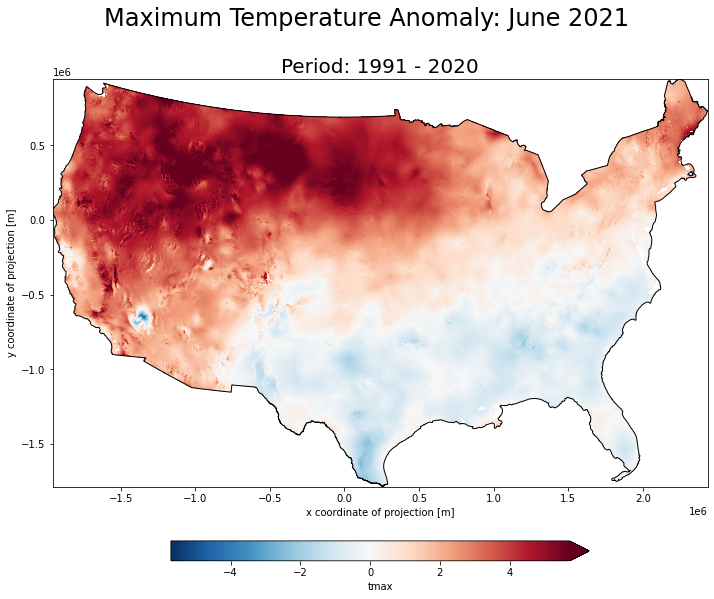

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,10))
tmaxJune21anomaly_masked.plot(ax=ax, robust=True, cbar_kwargs={"orientation": "horizontal","shrink": 0.5, "pad": 0.1})
conus_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'black')
ax.set_title('Period: 1991 - 2020', fontsize=20)
fig.suptitle("Maximum Temperature Anomaly: June 2021", fontsize=24)

END 